# Comparitive Analysis

### Setup

In [2]:
import nltk
nltk.download ("punkt")
import pandas as pd
from tqdm import tqdm
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import boto3

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Using Boto3, we accessed our text files that are stored in our `finaltranscriptionsbucket`. After running the code below, look at the JupyterLab file viewer on the left and the files, `text1`, `text2`, `text3`, and `text4` should be available to view. 

In [48]:
s3 = boto3.client('s3')

bucket_name = 'finaltranscriptionsbucket'
object_keys = [
    'MLLectureLDAandQDAZoomTranscript.txt',
    'MLLectureLDAandQDAWhisperTranscript.txt',
    'MLLectureRegularizationandSubsetSelectionZoomTranscript.txt',
    'MLLectureRegularizationandSubsetSelectionWhisperTranscript.txt'
]

texts_dict = {}
for i, key in enumerate(object_keys):
    local_file_path = f'text{i+1}'  
    s3.download_file(bucket_name, key, local_file_path)
    with open(local_file_path, "r") as f:
        texts_dict[f"text{i+1}"] = f.read()

df = pd.DataFrame({
    'lecture_name': ['MLLectureLDAandQDA', 'MLLectureLDAandQDA', 'MLLectureRegularizationandSubsetSelection', 'MLLectureRegularizationandSubsetSelection'],
    'transcriber': ['Zoom', 'Whisper', 'Zoom', 'Whisper'],
    'text': list(texts_dict.values())  
})

In [50]:
#For each transcription, tokenize the words and put them into a new column in the df
#This will allow for us to do text comparisons based on word frequency
tokens_list = []
for i, row in df.iterrows():
  row_tokens = nltk.word_tokenize(row.text)
  row_tokens = [token.lower() for token in row_tokens]
  tokens_list.append(row_tokens)
df['tokens'] = tokens_list

In [51]:
df

,lecture_name,transcriber,text,tokens
0,MLLectureLDAandQDA,Zoom,"Hi everyone, I hope you all had a won...","[hi, everyone, ,, i, hope, you, all, had, a, w..."
1,MLLectureLDAandQDA,Whisper,"Hi, everyone. I hope you all had a wonderful w...","[hi, ,, everyone, ., i, hope, you, all, had, a..."
2,MLLectureRegularizationandSubsetSelection,Zoom,"Hi, everyone. So thank you very much f...","[hi, ,, everyone, ., so, thank, you, very, muc..."
3,MLLectureRegularizationandSubsetSelection,Whisper,"Hi, everyone. So thank you very much for watch...","[hi, ,, everyone, ., so, thank, you, very, muc..."


# Comparative Frequency Analysis

### Calculates the log odds difference for each word in the word_counts dictionary/Counter
### Smoothing is added to avoid dividing by 0 for other small numbers, valuing differences in larger counts more than smaller
### i.e. depending on the smoothing, something showing up 2 times versus 0, will not have as high a difference as if it shows up 5 times versus 3

In [52]:
def log_odds_diff (word_counts_group1: dict, word_counts_group2: dict, smoothing=0.0) -> dict:

  log_odds = dict ()
  group1_count = sum([count for word, count in word_counts_group1.items()])
  group2_count = sum([count for word, count in word_counts_group2.items()])
  total_counts = word_counts_group1 + word_counts_group2

  for word, count in total_counts.items():
    group1_log = np.log((word_counts_group1[word]/group1_count)/(1-word_counts_group1[word]/group1_count) + smoothing)
    group2_log = np.log((word_counts_group2[word]/group2_count)/(1-word_counts_group2[word]/group2_count) + smoothing)
    log_odds[word] = group1_log - group2_log

  return log_odds

### Comparison for the lecture on LDA and QDA

In [53]:
zoom_counter1 = Counter(df.tokens[0])
whisper_counter1 = Counter(df.tokens[1])

In [54]:
#Calculate the log_odds difference
#We chose the smoothing based on trial and error of what seemed to represent the differences best
log_odds_score = log_odds_diff (zoom_counter1, whisper_counter1, smoothing=0.001)

#Print out the highest and lowest differences along with the scores and counts associated with each
print ("Distinctive words for Zoom")
for word, score in sorted (log_odds_score.items(), key=lambda x:x[1], reverse=True)[0:10]:
  print (word, f"{score:0.2f}", " ", zoom_counter1[word], "vs.", whisper_counter1[word])
print()
print ("Distinctive words for Whisper")
for word, score in sorted (log_odds_score.items(), key=lambda x:x[1], reverse=False)[0:10]:
  print (word, f"{score:0.2f}", " ", whisper_counter1[word], "vs.", zoom_counter1[word])

Distinctive words for Zoom
uh 1.48   23 vs. 0
current 1.12   14 vs. 0
thyracetopsa 0.63   6 vs. 0
land 0.63   6 vs. 0
-currency 0.63   6 vs. 0
suposa 0.55   5 vs. 0
-current 0.55   5 vs. 0
variance 0.54   30 vs. 14
color 0.49   6 vs. 1
certain 0.48   11 vs. 4

Distinctive words for Whisper
variance-covariance -1.37   19 vs. 0
sopoza -1.33   18 vs. 0
setosa -0.87   9 vs. 0
discern -0.70   18 vs. 6
covariance -0.61   30 vs. 14
decision -0.55   13 vs. 5
versicolor -0.48   4 vs. 0
off-diagonal -0.38   3 vs. 0
univariate -0.38   3 vs. 0
logit -0.38   3 vs. 0


### As you can see, there are quite a few differences between Zoom and Whisper. One interesting one is 'uh' for Zoom, which means Zoom transcriptions pick up on verbal pauses like this, but Whisper skips over them.

### Also, you can see that Zoom has 11 instances of "suposa" or "thyracetopsa" to Whisper's 0. But Whisper has 18 instances of "sopoza" which demonstrates a difference in spelling. One thing that's interesting is none of these are spelled correctly. This may be because of our teacher's poor pronunciation.

### Comparison for the lecture on Regularization and Subset Selection

In [55]:
zoom_counter2 = Counter(df.tokens[2])
whisper_counter2 = Counter(df.tokens[3])

In [56]:
#Calculate the log_odds difference
log_odds_score = log_odds_diff (zoom_counter2, whisper_counter2, smoothing=0.001)

#Print out the highest and lowest differences along with the scores and counts associated with each
print ("Distinctive words for Zoom")
for word, score in sorted (log_odds_score.items(), key=lambda x:x[1], reverse=True)[0:10]:
  print (word, f"{score:0.2f}", " ", zoom_counter2[word], "vs.", whisper_counter2[word])
print()
print ("Distinctive words for Whisper")
for word, score in sorted (log_odds_score.items(), key=lambda x:x[1], reverse=False)[0:10]:
  print (word, f"{score:0.2f}", " ", whisper_counter2[word], "vs.", zoom_counter2[word])

Distinctive words for Zoom
cross 1.77   26 vs. 0
-validation 1.51   19 vs. 0
seven 1.17   12 vs. 0
-square 1.05   10 vs. 0
last 0.85   12 vs. 2
true 0.83   14 vs. 3
basc 0.83   7 vs. 0
cell 0.73   12 vs. 3
-predictor 0.66   5 vs. 0
outer 0.66   5 vs. 0

Distinctive words for Whisper
cross-validation -1.71   24 vs. 0
squared -1.12   11 vs. 0
ridge -0.92   8 vs. 0
7 -0.90   15 vs. 3
lasso -0.79   15 vs. 4
2 -0.75   8 vs. 1
residual -0.74   14 vs. 4
l2 -0.66   5 vs. 0
1 -0.50   10 vs. 4
success -0.45   3 vs. 0


### In this one, we also see a number of glaring differences. One interesting one, is that Zoom splits "cross" and "-validation" up into two words. Whereas Whisper, more similarly to grammatical English, does not split them up.

### Zoom spells out numbers and Whisper does not

### Finally, Whisper captures mathemtical words like squared, ridge, and lasso better.

# Cosine Similarity Analysis

### We are going to proceed to use cosine similarity as one of the methods to see how similar two corpi of text are.

### **Note**: The files, `text1`, `text2`, `text3`, and `text4` should be available to view in JupyterLab file viewer on the left from the previous code we ran. Make sure to check the path of these files before running this code on your computer! The code below opens these text files. 

In [38]:
file_path = 'text1'  

with open(file_path, 'r') as file:
    content = file.read()
    text1 = content

In [40]:
file_path = 'text2' 

with open(file_path, 'r') as file:
    content = file.read()
    text2 = content

In [41]:
file_path = 'text3'  

with open(file_path, 'r') as file:
    content = file.read()
    text3 = content

In [42]:
file_path = 'text4'  

with open(file_path, 'r') as file:
    content = file.read()
    text4 = content

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

    return similarity[0][0]

similarity_score_1_2 = compute_similarity(text1,text2)
similarity_score_3_4 = compute_similarity(text3,text4)

In [44]:
print(similarity_score_1_2)
print(similarity_score_3_4)

0.9951874283305783
0.9973538205044212


In [45]:
print(compute_similarity(text1, text2))

0.9951874283305783


### We can see that the Zoom and Whisper transcriptions of the two lectures are both over 99% similar. A cosine similarity score closer to 1 means that the two corpi are the exact same, while one closer to 0 indicates that the two texts are completely different.

### Since we are comparing files which came from the same audio source, this is to be expected.

### A discrepency in this case may indicate that one--or both--of the transcription algorithms have detected some "hallucinated" text from background noise or may have left out some unintelligible speech.

# N-Gram Similarity Scoring

### Another method we may be able to use is an N-gram model to compare similar.

### N-gram works by taking combinations of n adjacent words, called 'grams' and compares the similar. For example, a 2-gram might be "generative method", a 3-gram might be "another generative method", and so on. This grades the content of each gram and evaluates the word similarity between them.

### One helpful example may be that many plagiarism detection algorithms use n-grams. But this use of n-grams is also why there are many false positives, as a frequently-used string may be detected as plagiarism.

In [46]:
def compute_ngram_similarity(text1, text2, n):

    vectorizer = TfidfVectorizer(ngram_range=(n, n))
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

    return similarity[0][0]

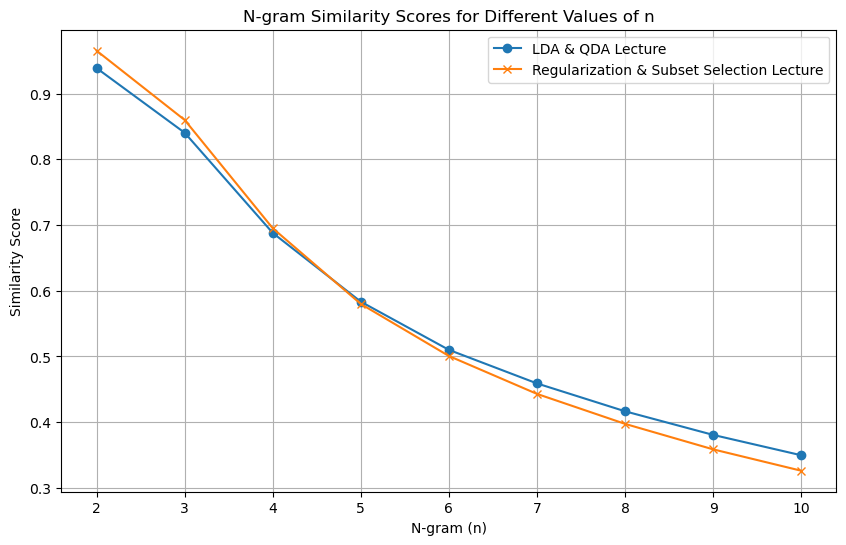

In [47]:
similarity_scores_1_2 = []
similarity_scores_3_4 = []

n_values = range(2, 11)

for n in n_values:
    score_1_2 = compute_ngram_similarity(text1, text2, n)
    score_3_4 = compute_ngram_similarity(text3, text4, n)
    similarity_scores_1_2.append(score_1_2)
    similarity_scores_3_4.append(score_3_4)

plt.figure(figsize=(10, 6))
plt.plot(n_values, similarity_scores_1_2, marker='o', label='LDA & QDA Lecture')
plt.plot(n_values, similarity_scores_3_4, marker='x', label='Regularization & Subset Selection Lecture')
plt.xlabel('N-gram (n)')
plt.ylabel('Similarity Score')
plt.title('N-gram Similarity Scores for Different Values of n')
plt.xticks(n_values)
plt.legend()
plt.grid(True)
plt.show()

### Our similarity starts off very high since smaller word chunks are more likely to be identical and decreases as the gram size increases.

### We can see that our text files both decrease in similarity at a similar rate as n increases. This is curious, since they originate from the same audio source.

### One possible explanation for this is that the Zoom transcription seems to be more raw, just trying to recognize words without much emphasis on grammar, whereas the Whisper transcription seems to have been corrected for proper punctuation and sentence structure and may have had words inserted based on probability that they should have appeared between in a corpus with proper grammar.